# Exercise: SINDy

Exercise on the implementation of SYNDy

Author: Stefano Pagani <stefano.pagani@polimi.it>.

Date: 2024

Course: Mathematical and numerical foundations of scientific machine learning.

Example adapted from:
[1] Brunton, S. L., & Kutz, J. N. (122).
Data-driven science and engineering: Machine learning,
dynamical systems, and control. Cambridge University Press.

In [1]:
# imports

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D
from scipy import integrate


In [2]:

# figure setting
rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]


Numerical simulation of the Lorenz System

In [3]:

dt = 0.01
T = 50


#  Reference timegrid t0 --> tN
t = np.arange(dt,T+dt,dt)
# Reference timegrid t2 --> tN+2 
t_p1 = np.arange(dt,T+2*dt,dt)

beta = 8/3
sigma = 10
rho = 28
n = 3

# Lorentz System dynamics
def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

np.random.seed(123)
# intial condition
x0 = (-8,8,27) # (x, y, z)

# ODE solver --> reference solution
xRef = integrate.odeint(lorenz_deriv, x0, t,rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))

# Shifted reference solution 
xRef_shifted = integrate.odeint(lorenz_deriv, x0, t_p1, rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))

# Simulate white noisy measurement
# TODO: what happens if the noise is generated with data correlation using np.random.multivariate_normal()?
noiseSigma = 0.0001*np.std(xRef)

# Note that derivatives are estimated numerical with added noise, they will be a mess =)
#xRef = xRef + np.random.multivariate_normal([0,0,0], noiseSigma*np.eye(3), xRef.shape[0])
#xRef_shifted = xRef_shifted + np.random.multivariate_normal([0,0,0], noiseSigma*np.eye(3), xRef_shifted.shape[0])


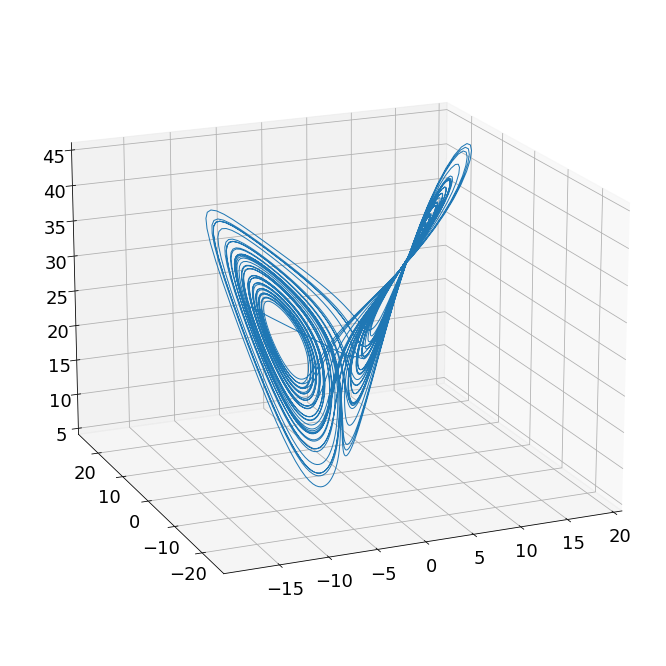

In [4]:

# plot

fig,ax = plt.subplots(1,1, subplot_kw={'projection': '3d'})

ax.plot(xRef[:,0], xRef[:,1], xRef[:,2],linewidth=1)
ax.view_init(18, -113)

#plt.subplot(1,2)
#ax.plot(xRef_shifted[:,0], xRef_shifted[:,1], xRef_shifted[:,2],linewidth=1)
#ax.view_init(18, -113)

plt.show()




In [5]:
## Compute Derivative
Dx_analytical = np.zeros_like(xRef)
Dx_numerical = np.zeros_like(xRef)

for j in range(len(t)):
    # exact
    Dx_analytical[j,:] = lorenz_deriv(xRef[j,:],0,sigma,beta,rho)
    # numerically approximated 
    Dx_numerical[j,:] = (xRef_shifted[j+1, :] - xRef[j, :])/dt
    
Dx_error = 100 * abs(Dx_numerical - Dx_analytical)/abs(Dx_analytical)
print('Max perc. error:', np.max(Dx_error))

Max perc. error: 296454.331733915


Task 1: complete the dictonary of candidate functions

In [6]:

## SINDy Function Definitions
# Construct appropriate basis functions library
# Note: evaluate Regressors matrix in the data 
def poolData(yin, nVars, polyorder):
    n = yin.shape[0]
    # RegressorsMatrix = np.zeros_like()
    yout = np.zeros((n,1))

    # poly order 0 (constants)
    yout[:,0] = np.ones(n)

    # poly order 1 (linear)
    for i in range(nVars):
        yout = np.append(yout, yin[:,i].reshape((yin.shape[0],1)), axis=1)

    # Nope: cross-terms are missing! --> no correlation can be modelled Ok dai
        
    # poly order 2 (quadratics)
    if polyorder >= 2:
        for i in range(nVars):
            yout =  np.append(yout, (yin[:,i]**2).reshape((yin.shape[0],1)), axis=1)

    # poly order 3 (cubics)
    if polyorder >= 3:
        for i in range(nVars):
            yout =  np.append(yout, (yin[:,i]**3).reshape((yin.shape[0],1)), axis=1)

    # TODO: REPLACE this stupid way of constructing the polynominal with what I did in MATLAB for polynomial regression
    # for loop over polyorder

    return yout

def SINDy(Theta, dXdt, lamb, n, maxiter):

    Xi = np.linalg.lstsq(Theta,dXdt,rcond=None)[0] # Initial guess: Least-squares

    # Solve iterative LS
    for k in range(maxiter):
        smallinds = np.abs(Xi) < lamb              # Find small coefficients 
        Xi[smallinds] = 0                          # and threshold
        for ind in range(n):                       # n is state dimension
            biginds = smallinds[:,ind] == 0
            # Regress dynamics onto remaining terms to find sparse Xi
            Xi[biginds,ind] = np.linalg.lstsq(Theta[:,biginds],dXdt[:,ind],rcond=None)[0]

    return Xi

def lorenz_SINDy(xState, time, regrCoeffs, nVars, polyorder):
    evalBasis = poolData(xState, nVars, polyorder=3)
    return evalBasis * regrCoeffs



In [7]:

Theta = poolData(xRef,n,3) # Up to third order polynomials
lamb = 0.0025 # sparsification knob lambda (acts as threshold to null less significant coefficients "artificially")
Xi = SINDy(Theta,Dx_analytical,lamb,n,10)

# vector of coefficients
print('Coefficients using Dx analytical:', Xi)

# Compute the reconstructed trajectory
# lorenz_SINDy(xState, n, 10)

xRecon = integrate.odeint(lorenz_SINDy, x0, t, (Xi, n, 10), rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))



Coefficients using Dx analytical: [[ 0.00000000e+00  1.51769072e+00  3.90177521e+00]
 [-1.00000000e+01 -5.39296294e-01  9.09479787e-02]
 [ 1.00000000e+01  6.45832349e+00 -5.36281456e-02]
 [ 0.00000000e+00 -1.66050537e-01 -4.24074320e+00]
 [ 0.00000000e+00  0.00000000e+00  1.07059405e+00]
 [ 0.00000000e+00  0.00000000e+00  2.26363694e-01]
 [ 0.00000000e+00  4.31968356e-03  1.63075668e-01]
 [ 0.00000000e+00 -8.06498514e-02  0.00000000e+00]
 [ 0.00000000e+00  1.24976080e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -5.00946454e-03]]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

Task 2: substitute exact derivative with a numerical approximation of the derivative

In [ ]:
# Test with numerical derivatives
Xi_usingNumerical = SINDy(Theta, Dx_numerical, lamb, n, 10)

# vector of coefficients
print('Coefficients using Dx numerical:', Xi_usingNumerical)

Coefficients using Dx numerical: [[ 4.24701035e-02  1.39915747e+00  6.44635604e+00]
 [-9.62439304e+00  3.00772559e-01  7.22911691e-02]
 [ 9.97105372e+00  6.21922174e+00 -5.06229194e-02]
 [ 0.00000000e+00 -1.45882722e-01 -4.51380112e+00]
 [ 0.00000000e+00  0.00000000e+00  9.28302434e-01]
 [ 0.00000000e+00  0.00000000e+00  2.93034890e-01]
 [ 0.00000000e+00  4.04021274e-03  1.76827565e-01]
 [-3.44459272e-03 -8.33699462e-02  0.00000000e+00]
 [ 0.00000000e+00  1.08573259e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -5.07405211e-03]]


Task 3: add noise to the measurement to test the robustness of the reconstruction

In [ ]:
# Add noise to the derivative